# CAFEPP (utilising cafepp_daily(.py))

***

## This example will produce a set of daily SST files across the V1 assimilation run (interpolated onto a 1x1 latxlon grid), and upon success, generate an average over the nino3.4 region and plot the time-series.

***

# Various settings required:

## BATCH determines whether it will be sent to the queue via qsub command or run interactively.

## CLEAN determines whether the run directory will be emptied prior to processing.

In [8]:
print('BEGIN')

from __future__ import print_function #this is to allow print(,file=xxx) feature

import datetime
import shutil
import os

dvar='tos' #variable to generate as well as further proces and plot.

BATCH=True #submit to queue
BATCH=False #run interactively but in a batch temporary area.

CLEAN=False #don't remove rundir, just use it.
CLEAN=True #remove rundir and recreate it.

if(BATCH):
  print('Submitting to queue.')

if(CLEAN):
  print('Removing run directory and reestablish it.')

predir='/short/v14/mac599'
topdir=predir+'/'+'cafepp'
script='cafepp_daily_assimilation_year_month.py'

rundir=topdir+'/'+'rundir20171124143249'
rundir=topdir+'/'+'rundir20171128165302'
rundir=topdir+'/'+'rundir'+datetime.datetime.today().strftime('%Y%m%d%H%M%S')
rundir=topdir+'/'+'rundir' #temporary running directory

print('Running in directory '+rundir)
print('Using script '+script)

srcdir='/home/599/mac599/decadal' #main cafepp code
prodir=srcdir+'/paper_analysis' #project directory

print('END')

BEGIN
Removing run directory and reestablish it.
Running in directory /short/v14/mac599/cafepp/rundir
Using script cafepp_daily_assimilation_year_month.py
END


# Here we make directories, copy across necessary JSON and python code.

In [9]:
print('BEGIN')

print('copying json files, generating symlinks, cmor tables, queue script, if necessary.')
if(os.path.exists(rundir) and CLEAN):
  shutil.rmtree(rundir)
  os.mkdir(rundir)
  os.mkdir(rundir+'/'+'JsonTemplates') # exist_ok=True only python3
elif(not os.path.exists(rundir)):
  os.mkdir(rundir)
  os.mkdir(rundir+'/'+'JsonTemplates') # exist_ok=True only python3

os.symlink(predir+'/'+'CMIP6',rundir+'/'+'CMIP6')
os.symlink(prodir+'/'+'TablesTemplates',rundir+'/'+'TablesTemplates')
os.symlink(prodir+'/'+'cmip6-cmor-tables',rundir+'/'+'cmip6-cmor-tables')

if(BATCH):
  ifh=open(prodir+'/'+'qjob.csh')
  ofh=open(rundir+'/'+'qjob.csh','w')
  for i,line in enumerate(ifh):
    line=line.replace('RUNDIR',rundir)
    print(line,file=ofh,end='')
  ifh.close()
  ofh.close()

vector_string=['decadal_diag.py','cafepp_daily.py','app_funcs.py']
for i,file_now in enumerate(vector_string):
  print('Copying '+srcdir+'/'+file_now+' to ',rundir)
  shutil.copyfile(srcdir+'/'+file_now,rundir+'/'+file_now)

vector_string=['cafepp_daily_assimilation_year_month.py']
for i,file_now in enumerate(vector_string):
  print('Copying '+prodir+'/'+file_now+' to ',rundir)
  shutil.copyfile(prodir+'/'+file_now,rundir+'/'+file_now)
  
vector_string=[]
vector_string.append(script) #may need to do edits?
vector_string.append('cafepp_daily_assimilation.json')
vector_string.append('cafepp_daily_forecast_experiments.json')
vector_string.append('JsonTemplates'+'/'+'cafepp_csiro-gfdl.json')
vector_string.append('JsonTemplates'+'/'+'cafepp_vars.json')

for i,file_now in enumerate(vector_string):
  print('Copying '+prodir+'/'+file_now+' to ',rundir)
  shutil.copyfile(prodir+'/'+file_now,rundir+'/'+file_now)
  
print('Processing cafepp_daily_assimilation.json')
ifh=open(prodir+'/'+'cafepp_daily_assimilation.json')
ofh=open(rundir+'/'+'cafepp_daily_assimilation.json','w')
for i,line in enumerate(ifh):
  token1=[str(x) for x in line.split(':')]
  token2=(token1[0].replace(' ',''))
  token3=(token2.replace('"',''))
  if(token3=='dvar'):
    line='     "dvar":"'+dvar+'",\n'
  elif(token3=='grid_label'):
    line='     "grid_label":"gr2",\n'
  elif(token3=='grid'):
    line='     "grid":"data regridded via linear interpolation to a 1x1 degree latxlon  (180x360)grid from the native 300x360 latxlon tri-polar grid",\n'
  print(line,file=ofh,end='')
ifh.close()
ofh.close()

#break
print('END')

BEGIN
copying json files, generating symlinks, cmor tables, queue script, if necessary.
Copying /home/599/mac599/decadal/decadal_diag.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/cafepp_daily.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/app_funcs.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_assimilation_year_month.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_assimilation_year_month.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_assimilation.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_forecast_experiments.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/JsonTemplates/cafepp_csiro-gfdl.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/JsonT

# We establish where to execute the job.

## We import a function that is relatively simple to loop over all necessary years, months, ensembles as required.
## Different applications will require a different module to be written (often small and relatively simple).

In [10]:
print('BEGIN')

os.chdir(rundir)
print('Current Working Directory=',os.getcwd())

import getpass
import numpy as np
import numpy.ma as ma
import os
from time import strftime
import netCDF4
from math import radians, cos, sin, asin, sqrt
import seawater
#import sys
import getopt
import string
from decadal_diag import MustHaveAllLevs,diag_acc_drake,diag_acc_africa,diag_mozmbq,diag_aabw,diag_nadw,\
diag_pp,diag_nflux,diag_ep,diag_ssh,diag_moc,diag_moc_atlantic,diag_moc_pacific,diag_moc_indian,\
diag_shice_cover,diag_nhice_cover,diag_nino34,xtra_nino34,init_data,sum_data,avg_data,filemonth_index,\
data_wavg,time_avg,diag_nhblocking_index,diag_rws5,finish,diag_msftyyz,make_mask3D,diag_mfo,transPort,\
diag_rws500,create_odirs,create_ofils,diag_iod,diag_iod,xtra_iod,atmos_vertical_interpolate,diag_isothetaoNc,\
calc_iso_surface,calc_isoN,grab_var_meta,diag_psl,diag_hfls,diag_heat_content,diag_salt_content,\
diag_north_heat_trans,diag_north_salt_trans,ocean_vertical_interpolate,diag_thetao0to80m,diag_varNl,\
uncomment_json,process_json,get_daily_indices_for_monthlyave,diag_maxdTbydz,diag_depmaxdTbydz,\
diag_dTbydz,shade_2d_simple,shade_2d_latlon,diag_zmld_boyer,zmld_boyer,sigmatheta,diag_zmld_so,\
zmld_so,diag_spice,spice,diag_bigthetao,diag_soabs,diag_spiciness,diag_potrho,fractional_year_from_num2date,\
new_monthly_array_shape,restrict_input_files

import cmor
import cdtime
from app_funcs import *
import json
import pprint
from datetime import date
import filecmp
from shutil import copyfile
import cdms2
import inspect
import socket
import glob
from matplotlib.mlab import griddata
import scipy.sparse as sps
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from gridfill import fill as poisson_fill

import cafepp_daily_assimilation_year_month
print('END')

BEGIN
Current Working Directory= /short/v14/mac599/cafepp/rundir
END


# Either submit it to the queue or run interactively.

In [11]:
print('BEGIN')
if(BATCH):
  os.chmod(script,500)
  os.system('qsub '+rundir+'/'+'qjob.csh')
else:
  print('Current Working Directory=',os.getcwd())
  os.chdir(rundir)
  cafepp_daily_assimilation_year_month.main(rundir)
print('END')

BEGIN
Current Working Directory= /short/v14/mac599/cafepp/rundir
ybeg_now,mbeg_now= 2002 1
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20020101-20020131.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20020101-20020131.nc  exists
ybeg_now,mbeg_now= 2002 2
MAIN
hostname= raijin3
Running cafepp from JSON instructions

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20021001-20021031.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20021001-20021031.nc  exists
ybeg_now,mbeg_now= 2002 11
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20021101-20021130.nc

Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20031101-20031130.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20031101-20031130.nc  exists
ybeg_now,mbeg_now= 2003 12
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaco

MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20040901-20040930.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20040901-20040930.nc  exists
ybeg_now,mbeg_now= 2004 10
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found 

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20050901-20050930.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20050901-20050930.nc  exists
ybeg_now,mbeg_now= 2005 10
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20051001-20051031.nc

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20060901-20060930.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20060901-20060930.nc  exists
ybeg_now,mbeg_now= 2006 10
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20061001-20061031.nc

Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20071001-20071031.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20071001-20071031.nc  exists
ybeg_now,mbeg_now= 2007 11
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaco

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20080801-20080831.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20080801-20080831.nc  exists
ybeg_now,mbeg_now= 2008 9
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20080901-20080930.nc


Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20090801-20090831.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20090801-20090831.nc  exists
ybeg_now,mbeg_now= 2009 9
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20090901-20090930.nc


Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20100801-20100831.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20100801-20100831.nc  exists
ybeg_now,mbeg_now= 2010 9
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20100901-20100930.nc


Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20110801-20110831.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20110801-20110831.nc  exists
ybeg_now,mbeg_now= 2011 9
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20110901-20110930.nc


fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20120701-20120731.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20120701-20120731.nc  exists
ybeg_now,mbeg_now= 2012 8
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hos

Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20130601-20130630.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20130601-20130630.nc  exists
ybeg_now,mbeg_now= 2013 7
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20130701-20130731.nc


Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20140601-20140630.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20140601-20140630.nc  exists
ybeg_now,mbeg_now= 2014 7
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20140701-20140731.nc


Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20150601-20150630.nc
No Clobber set and  CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20150601-20150630.nc  exists
ybeg_now,mbeg_now= 2015 7
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
fh_printfile= <ipykernel.iostream.OutStream object at 0x7f67da5d3a10>
Found required output experiment : coupled_da/OUTPUT-2step-nobreeding-carbon2
hostname= raijin
storage_machine_no1= tube-hba
['/short/v14/mac599/anaconda3/envs/cafepp_27_scipy/lib/python2.7/site-packages/ipykernel_launcher.py', '-f', '/home/599/mac599/.local/share/jupyter/runtime/kernel-a0928736-f1ef-436c-87b5-df2f38c90182.json']
Found required output variable: tos
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/tos/gr2/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_20150701-20150731.nc


# Now to plot data, this will depend on success of previous steps producing necessary outputs with cafepp(_daily).

BEGIN.
lat= [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
lon= [ 190.5  191.5  192.5  193.5  194.5  195.5  196.5  197.5  198.5  199.5
  200.5  201.5  202.5  203.5  204.5  205.5  206.5  207.5  208.5  209.5
  210.5  211.5  212.5  213.5  214.5  215.5  216.5  217.5  218.5  219.5
  220.5  221.5  222.5  223.5  224.5  225.5  226.5  227.5  228.5  229.5
  230.5  231.5  232.5  233.5  234.5  235.5  236.5  237.5  238.5  239.5]


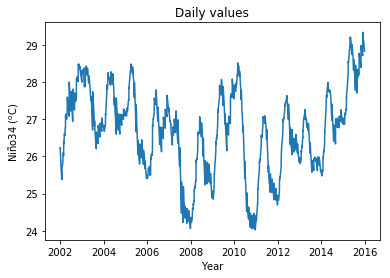

END


In [27]:
print('BEGIN.')

import math

rad = 4.0*math.atan(1.0)/180.0
#print('rad=',rad)
clat=np.cos(lat[:]*rad)
#print('clat=',clat)

os.chdir(rundir)

files_string='CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Oday/'+dvar+'/gr2/v20171025/'+dvar+'_Oday_historical_CAFE-1-0_r1i1p2f1_gr2_????????-????????.nc'
files=glob.glob(files_string)
files=restrict_input_files(sorted(files))

ifhN=netCDF4.MFDataset(files)
ifh0=netCDF4.Dataset(files[0])

time=ifhN.variables['time']
lat=ifh0.variables['lat']
lon=ifh0.variables['lon']

print('lat=',lat[85:95])
print('lon=',lon[190:240])

nino34=np.average(np.average(ifhN.variables['tos'][:,85:95,190:240],axis=1,weights=clat[85:95]),axis=1) #need to add in area weighting strictly

'''
print('time.units=',time.units)
print('time.calendar=',time.calendar)
print('time=',time)
print('time[:]=',time[:])
'''

date_time_stamp=netCDF4.num2date(time[:],time.units,time.calendar)

'''
print('date_time_stamp=',date_time_stamp)
num_stamp=netCDF4.date2num(date_time_stamp,time.units,time.calendar)
print('num_stamp=',num_stamp)
print('year_fraction=',year_fraction)
'''
year_fraction=fractional_year_from_num2date(date_time_stamp,time.calendar)

%matplotlib inline

plt.title('Daily values')
#plt.plot(num_stamp,nino34[:])
plt.plot(year_fraction,nino34[:])
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()
print('END')

In the following monthly values will be calculated and then plotted.

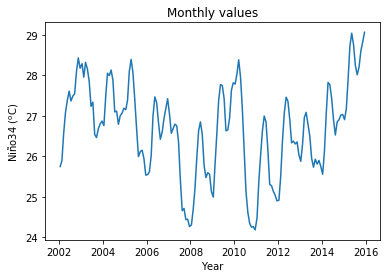

In [13]:
indices=get_daily_indices_for_monthlyave(time,date_time_stamp,time.calendar) #a list
nino34_monthly=np.zeros(len(indices))
for month in range(0,len(indices)):
  nino34_monthly[month]=np.average(nino34[indices[month]])

year_fraction_monthly=np.zeros(len(indices))
for month in range(0,len(indices)):
  year_fraction_monthly[month]=np.average(year_fraction[indices[month]])
  
%matplotlib inline

plt.plot(year_fraction_monthly,nino34_monthly)
plt.title('Monthly values')
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()

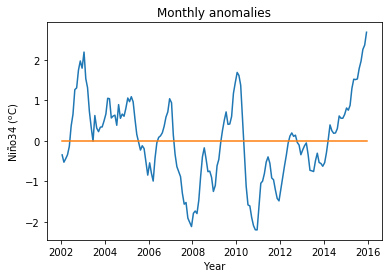

In [14]:
ybeg=date_time_stamp[0].year
yend=date_time_stamp[-1].year
ydiff=yend-ybeg+1
nmy=12

nino34_monthly_reshaped=np.reshape(nino34_monthly,new_monthly_array_shape(nino34_monthly.shape,ydiff,nmy))
climatology=np.average(nino34_monthly_reshaped,axis=0)
nino34_monthly_climatology=np.expand_dims(climatology,0)
nino34_monthly_climatology=np.tile(nino34_monthly_climatology,(ydiff,1))
nino34_monthly_climatology_flat=nino34_monthly_climatology.flatten()
nino34_monthly_anomaly=nino34_monthly-nino34_monthly_climatology_flat

%matplotlib inline

zero=np.zeros(len(indices))
plt.plot(year_fraction_monthly,nino34_monthly_anomaly)
plt.plot(year_fraction_monthly,zero)

plt.title('Monthly anomalies')
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()